In [1]:
# Standard library imports
import logging
import time
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import TwoQubitWeylDecomposition

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli, random_su4
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp


# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

Propagating (full history), max weight: 3:   0%|          | 0/24 [00:00<?, ?it/s]

0.048090447468928155


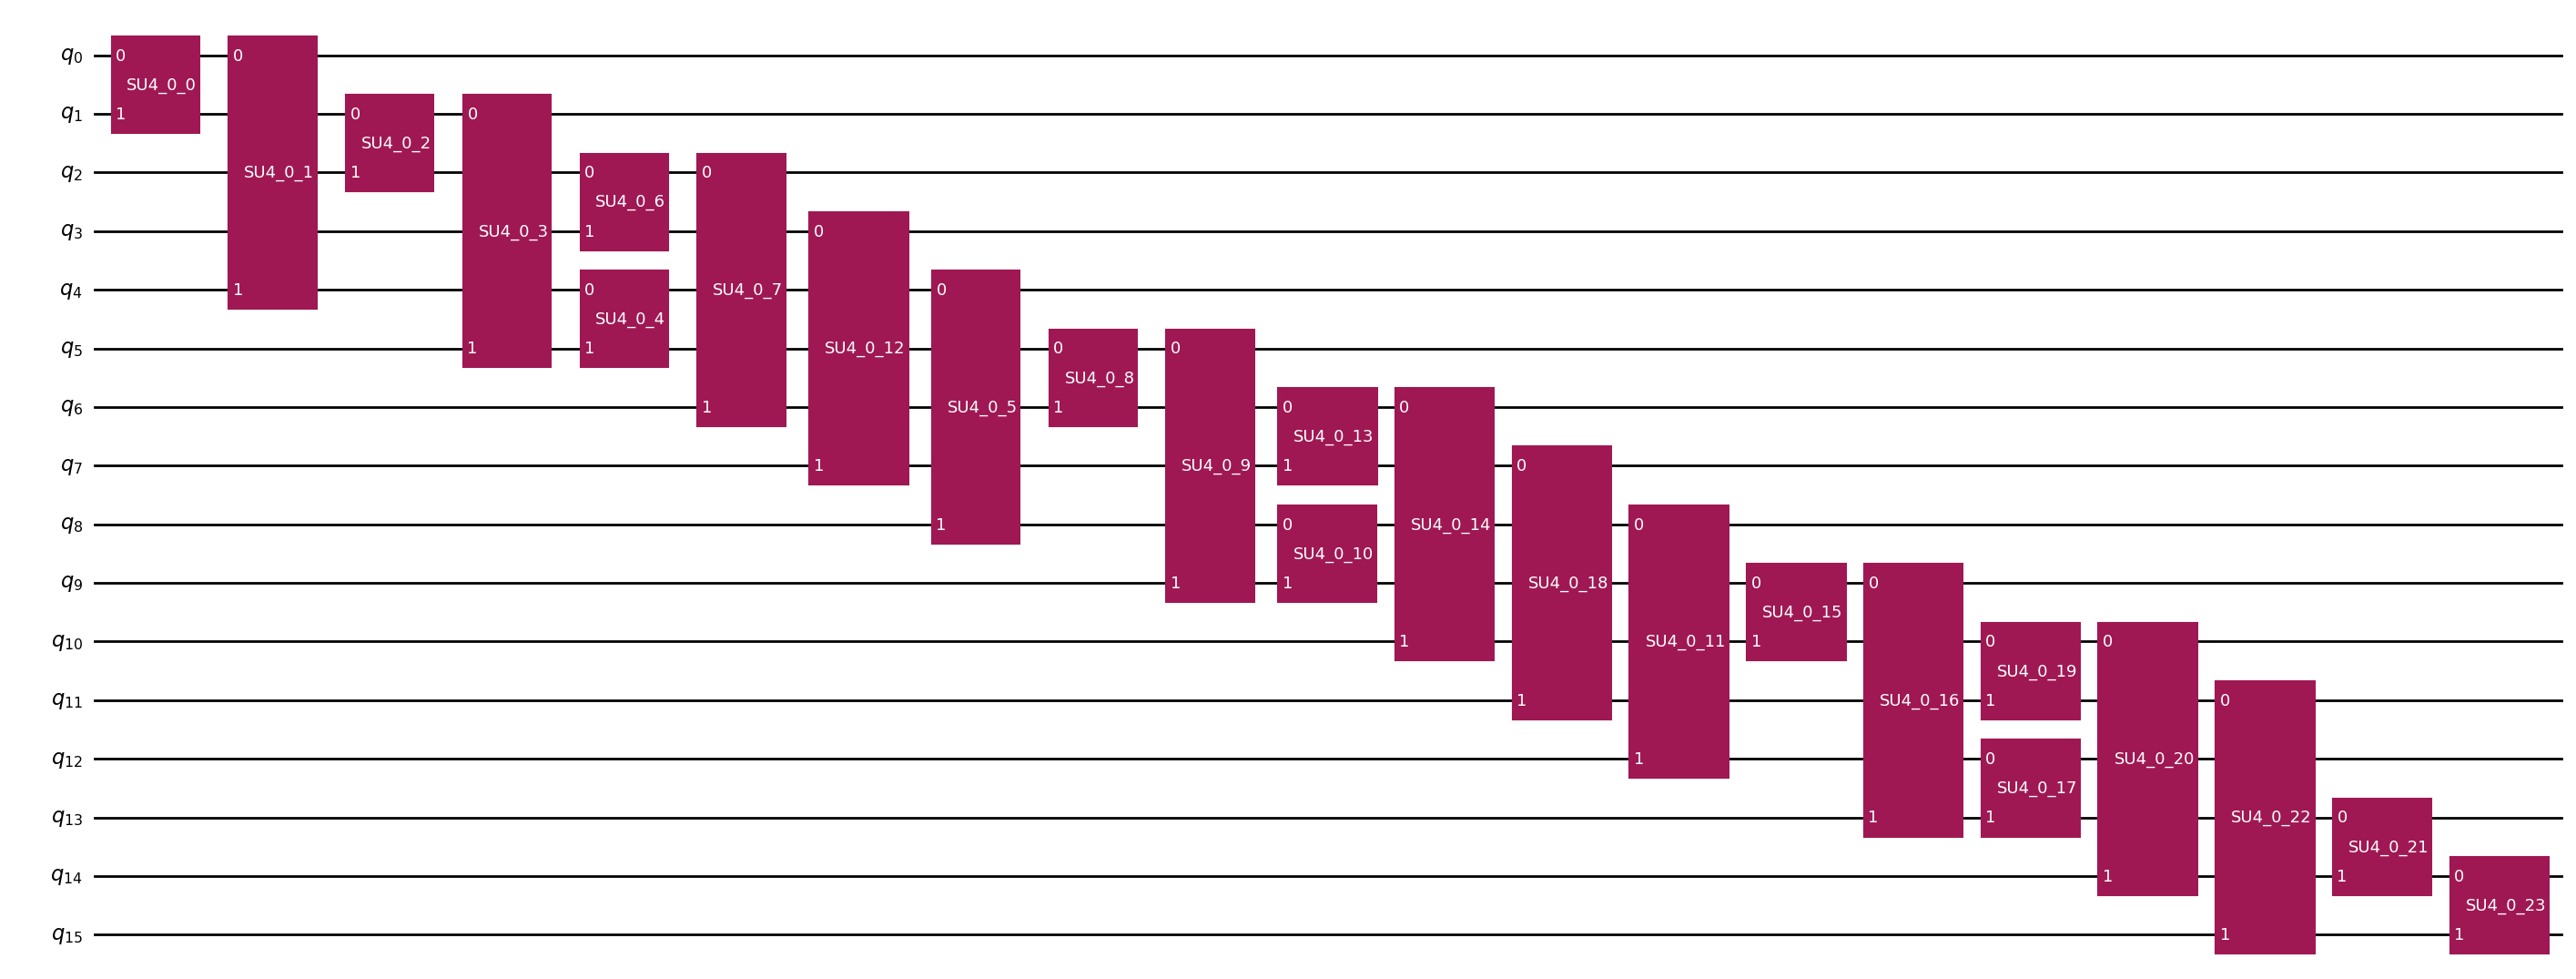

In [2]:
nx = ny = 4
L = 1

# 0) 构造电路与初始 PauliTerm
qc_2d = staircasetopology2d_qc(nx, ny, L)
qc_2d.draw(output='mpl',fold= -1);

n = qc_2d.num_qubits
pauli_label =  'Z' + "I" * (n - 1) 
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

layers_2d = prop_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_2d = prop_2d.expectation_pauli_sum(layers_2d[-1], product_label)
print(exp_2d)


Propagating (full history), max weight: 3:   0%|          | 0/24 [00:00<?, ?it/s]

-0.021152366746933767


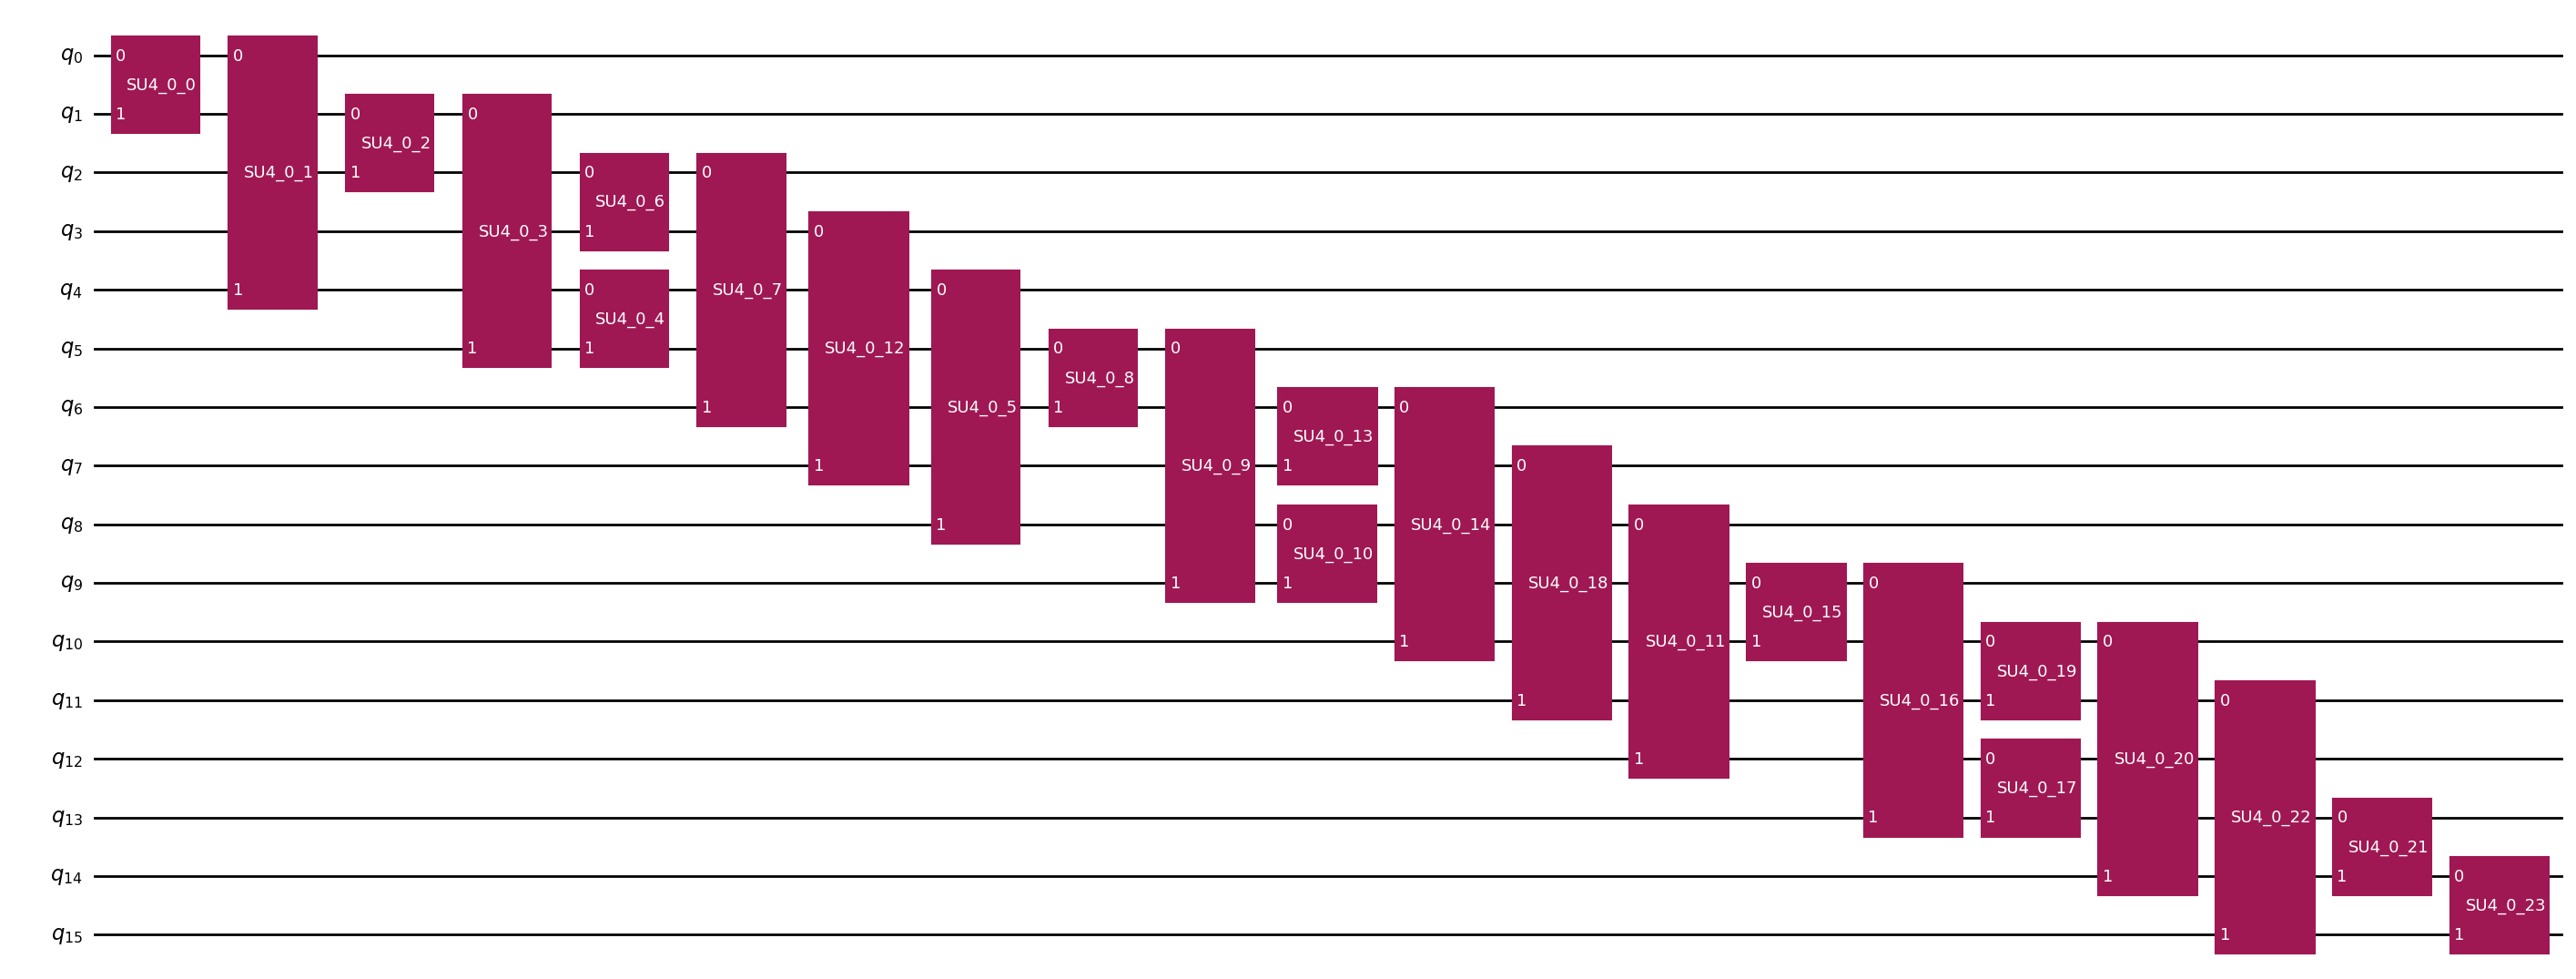

In [3]:
nx, ny = 4,4
L = 1

# 0) 构造电路与初始 PauliTerm
qc_2d = staircasetopology2d_qc(nx, ny, L)
qc_2d.draw(output='mpl',fold= -1);

n = qc_2d.num_qubits
pauli_label =  'Z' + "I" * (n - 1) 
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, n)
product_label = "0" * n
prop_2d = PauliPropagator(qc_2d)

layers_2d = prop_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_2d = prop_2d.expectation_pauli_sum(layers_2d[-1], product_label)
print(exp_2d)

In [4]:
sv = Statevector.from_instruction(qc_2d)
P = Pauli(pauli_label)
exp_sv = np.real_if_close(sv.expectation_value(P))
print("Statevector expectation:", exp_sv)

Statevector expectation: -0.020981266032754162


Propagating (full history), max weight: 3:   0%|          | 0/360 [00:00<?, ?it/s]

-0.0019275725661385915


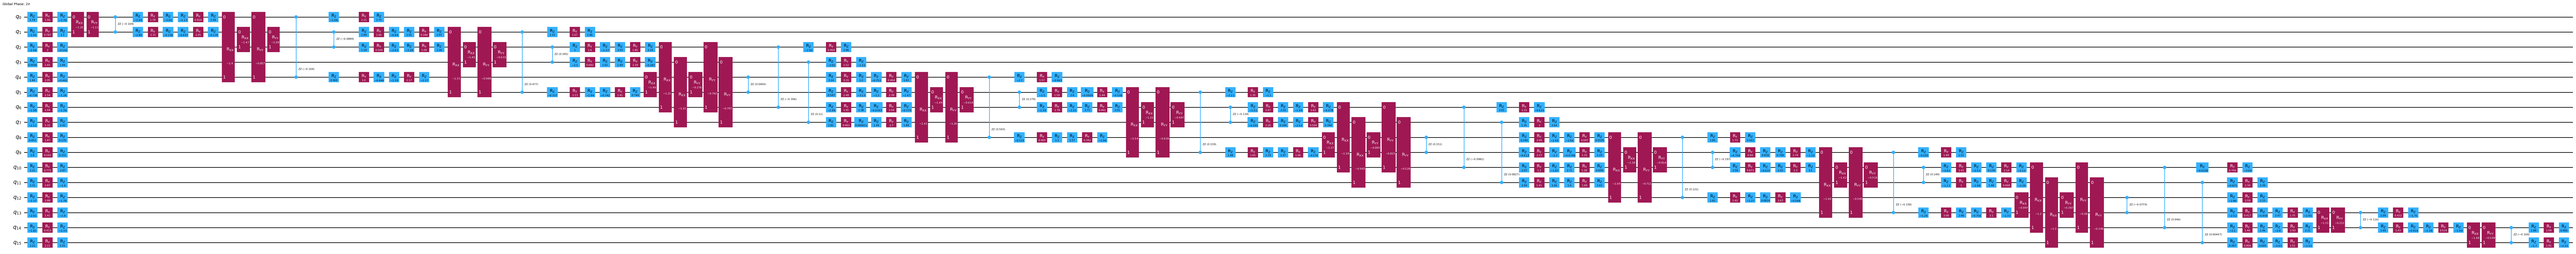

In [5]:
qc_2d_kak = su4_kak_reconstruct(qc_2d)

qc_2d_kak.draw(output='mpl',fold= -1);

prop_kak_2d = PauliPropagator(qc_2d_kak)

layers_kak_2d = prop_kak_2d.propagate(init_term, max_weight=3, use_parallel=False)

exp_kak_2d = prop_kak_2d.expectation_pauli_sum(layers_kak_2d[-1], product_label)
print(exp_kak_2d)

In [6]:
# L = 1, 15w样本
# L = 2, 30w样本

nx, ny = 5, 5
L_vals = [4]            
M = 10000 * 200
max_kk = 6

# 准备输出目录
out_dir = "results/kak"
os.makedirs(out_dir, exist_ok=True)

In [7]:
# for L in L_vals:

#     # === 0) 构造电路 & 初始 PauliTerm ===
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     qc_2d = su4_kak_reconstruct(qc_2d)
#     n = qc_2d.num_qubits

#     pauli_label = 'Z' + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     product_label = "0" * n
#     prop_2d = PauliPropagator(qc_2d)

#     # === 1) Monte-Carlo 抽样一次（对所有 k 共享） ===
#     mc = MonteCarlo(qc_2d)
#     _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, M=M)

#     # === 2) 计算权重直方图 (归一化成概率密度) ===
#     bins = np.arange(0.5, n + 1.5)
#     hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)

# # 下面让我们把它和“概率密度”都一起算出来（可选）
#     hist_vals = hist_counts / float(len(last_weights))  # 如果还想要概率密度

#     # === 3) 估计所有 k 下的 MC MSE（一次性拿到 cumulative 和 layer） ===
#     mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
#                                                          product_label=product_label)
        
#     cum   = mse_mc_results_dict['cumulative']
#     layer = mse_mc_results_dict['layer']

#     # === 4) 把本次 L 的结果打包成一个 dict，仅包含该 L 的内容 ===
#     result_for_L = {"L": L,
#                     "weight_hist": {"hist_vals": hist_vals.tolist(),
#                                     "bin_edges": bin_edges.tolist(),
#                                     "hist_counts": hist_counts.tolist()},
#                     "cum_mse":  { str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1) },
#                     "weight_mse": { str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1) }}

#     # === 5) 写成 JSON 文件，文件名里带上 L 的值 ===
#     filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
#     with open(filename, 'w') as f:
#         json.dump(result_for_L, f, indent=2, ensure_ascii=False)

#     print(f" 已完成 L={L} 的 MC 采样，结果保存到：{filename}")

In [8]:
L_vals = [1,2,3,4]
mc_results_dict = {"weight_mse":  { str(k): [] for k in range(max_kk + 1) },
                   "cum_mse":     { str(k): [] for k in range(max_kk + 1) },
                   "weight_hist": {}}

# 3) 对每个 L，打开对应的 JSON 文件，把数据载入并追加到 mc_results_dict

for L in L_vals:
    filename = os.path.join(out_dir, f"kak_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    # a) 把单层 ΔMSE (weight_mse) 和 累计 MSE (cum_mse) 追加到各自列表里
    #    注意：JSON 里键是字符串 "0","1",…，我们这里保持一致
    for k in range(max_kk + 1):
        mc_results_dict["weight_mse"][str(k)].append(data_L["weight_mse"][str(k)])
        mc_results_dict["cum_mse"][str(k)].append(data_L["cum_mse"][str(k)])

    # b) 把直方图 “weight_hist” 也存进去：直接用 L 的字符串作为键，
    #    值仍然是一个包含 hist_vals/list 和 bin_edges/list 的 dict
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


[0.011405555555555556, 0.0007611111111111111, 0.0001611111111111111, 5.555555555555556e-05]
[0.00115, 0.00019444444444444443, 8.333333333333333e-05, 1.1111111111111112e-05]
[4.375e-05, 7.5e-06, 1.25e-06, 1.25e-06]
[2.2e-05, 6e-06, 1e-06, 5e-07]


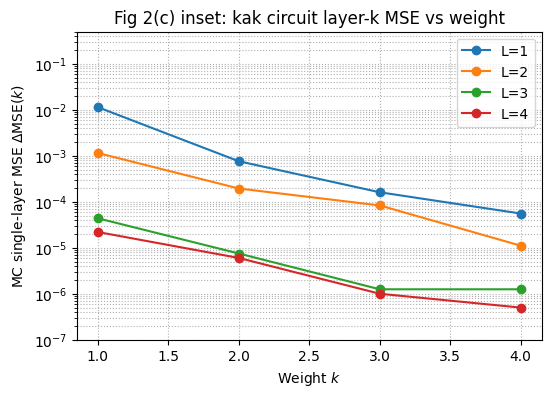

In [18]:
# —— 单层 ΔMSE vs weight (Fig 2c) —— 
plt.figure(figsize=(6,4))
for L in L_vals:
    kk_vals = list(range(1,5))
    ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
    print(ys)
    plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
plt.yscale('log')
plt.ylim(1e-7,5e-1)  # 设置 y 轴最小值为 10e-8
plt.xlabel('Weight $k$')
plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
plt.title('Fig 2(c) inset: kak circuit layer-k MSE vs weight')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


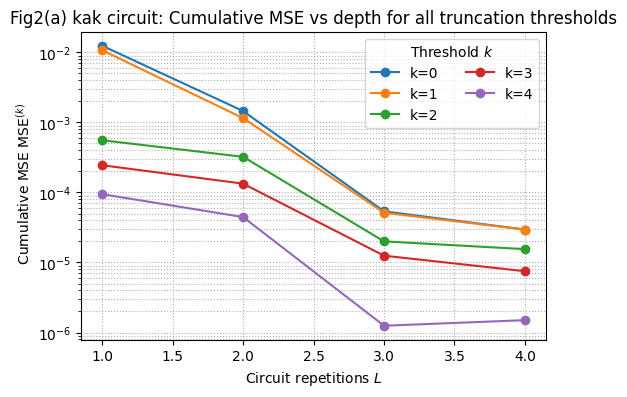

In [20]:
# —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(6, 4))
for kk in range(0,5):
    ys = mc_results_dict['cum_mse'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xlabel('Circuit repetitions $L$')
plt.ylabel(' Cumulative MSE $\\mathrm{MSE}^{(k)}$')
plt.title('Fig2(a) kak circuit: Cumulative MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show()

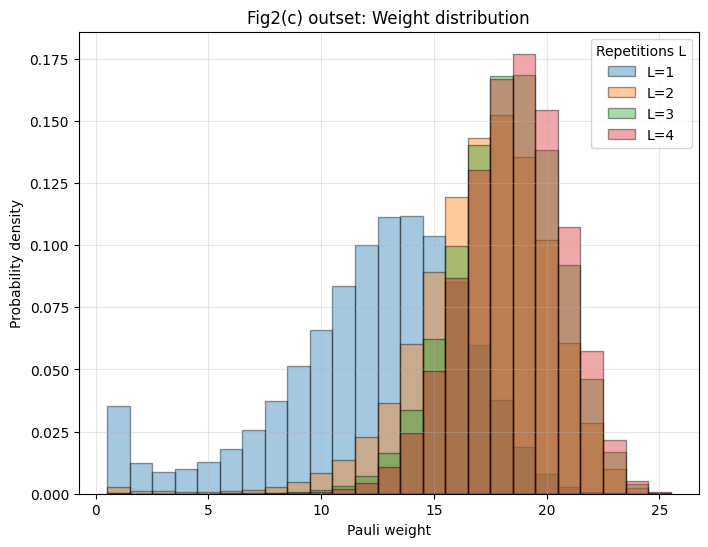

In [11]:
plt.figure(figsize=(8,6))

for L in L_vals:
    entry     = mc_results_dict['weight_hist'][str(L)]  # 注意用 str(L) 或者你已转换成 int 的 key
    hist_vals = entry['hist_vals']    # 已经是 float 列表
    bin_edges = entry['bin_edges']    # 已经是 float 列表，长度 = len(hist_vals)+1

    # 推荐用 zip 来计算每对相邻边界的差值
    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # 画条形图
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Fig2(c) outset: Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()


In [12]:
k_vals = [1,2,3,4]
L_vals = [4]
nx = ny = 5

# for L in L_vals:
#     # Initialize dictionaries to collect results for this specific L
#     prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
#                          'exp_time':     {k: [] for k in k_vals},
#                          'expectation':  {k: [] for k in k_vals}}

#     # Build the 2D circuit and initial PauliTerm
#     qc_2d = staircasetopology2d_qc(nx, ny, L)
#     qc_2d = su4_kak_reconstruct(qc_2d)
#     n = qc_2d.num_qubits
#     pauli_label = "X" + "I" * (n - 1)
#     key = encode_pauli(Pauli(pauli_label))
#     init_term = PauliTerm(1.0, key, n)
#     prop_2d = PauliPropagator(qc_2d)

#     # For each k, propagate and measure, then store timing and expectation
#     for k in k_vals:
#         t0 = time.time()
#         layers_trunc = prop_2d.propagate(init_term, max_weight=k, 
#                                          return_history=False, 
#                                          use_parallel=False)
#         t_prop = time.time() - t0

#         t1 = time.time()
#         est_exp = prop_2d.expectation_pauli_sum(layers_trunc, "0" * n)
#         t_exp = time.time() - t1

#         prop_results_dict['prop_time'][k].append(t_prop)
#         prop_results_dict['exp_time'][k].append(t_exp)
#         prop_results_dict['expectation'][k].append(est_exp)

#     # Write out a JSON file for this L
#     output_path = f"results/kak/kak_prop_results_L{L}.json"
#     with open(output_path, "w") as f:
#         json.dump(prop_results_dict, f, indent=2)

#     print(f"Results for L={L} saved to {output_path}")


In [13]:
# 3min59s 709gates

In [14]:
# 50% 进度，70%内存

In [15]:
L_vals = [1,2,3,4] # L_vals= [1,2,3,4]

# Prepare an empty merged dictionary with the same structure as before
prop_results_dict = {'prop_time':    {k: [] for k in k_vals},
                     'exp_time':     {k: [] for k in k_vals},
                     'expectation':  {k: [] for k in k_vals}}

out_dir_kak = os.path.join("results", "kak")
for L in L_vals:
    filename = os.path.join(out_dir_kak, f"kak_prop_results_L{L}.json")
    with open(filename, "r") as f:
        raw = json.load(f)

    # Combine the lists for each metric and k
    for metric, subdict in raw.items():
        for k_str, v_list in subdict.items():
            k = int(k_str)
            prop_results_dict[metric][k].extend(v_list)

# Now prop_results_dict has the exact same format as before,
# with data from all L values merged together.


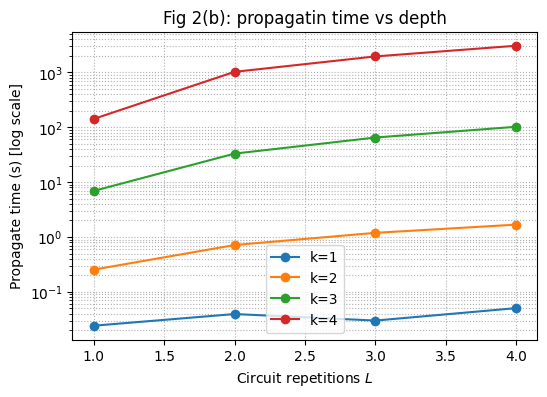

In [21]:
# 2) 精确截断 propagate 时间 vs 深度 (Fig 2(b))，y 轴改为 log10
plt.figure(figsize=(6, 4))
for k in k_vals:
    ts = prop_results_dict['prop_time'][k]
    plt.plot(L_vals, ts, marker='o', label=f'k={k}')
plt.yscale('log')  # 切换到对数刻度（10 为底）
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Propagate time (s) [log scale]')
plt.title('Fig 2(b): propagatin time vs depth')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.show()


In [17]:
# pip install uv